# 9. BERT Text Clustering

## 載入套件 & 連接雲端硬碟 & 資料前處理


In [1]:
# 連接雲端資料夾
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks')
os.listdir() # 確認目錄內容

Mounted at /content/drive


['data.zip',
 'Arial Unicode MS.ttf',
 'SourceHanSansTW-Regular.otf',
 'TaipeiSansTCBeta-Regular.ttf',
 'dict',
 'data',
 '俄烏.csv',
 'basic_netWork.html',
 'pers_netWork.html',
 'max_sub.html',
 'lda_zh.html',
 '06-pig_Social_Media.ipynb',
 '03-pig_team_bert.ipynb',
 '05_pig_team_LLM.ipynb',
 '02-pig_team_lda.ipynb',
 'netWork.html',
 '07-pig_graph.ipynb',
 '01-pig_team.ipynb',
 'entity_table_俄烏.csv',
 'sentence_table_俄烏.csv',
 'pos_table_俄烏.csv',
 '04-pig_term_ner.ipynb']

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install jieba

In [4]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

In [5]:
!pip install sentence_transformers
!pip install ckip_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [6]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

**BERTopic套件**

In [7]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 4.0 MB/s eta 0:00:00


In [8]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

In [9]:
# 讀入資料集
df = pd.read_csv('./俄烏.csv')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

資料前處理：

In [10]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1645663423....,[問卦]國軍如出兵烏俄戰爭可做什麼讓大家驚艷？,2022-02-24 08:43:41,大家好\n烏克蘭 俄羅斯戰爭一觸即發\n中華民國台灣一向很熱心想積極參與國際事務\n軍力排名...,大家好烏克蘭 俄羅斯戰爭一觸即發中華民國台灣一向很熱心想積極參與國際事務軍力排名也是全球第2...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1645664873....,Re:[問卦]國軍如出兵烏俄戰爭可做什麼讓大家驚艷？,2022-02-24 09:07:51,怎麽支援？？\n\n中華民國國軍 可以拿來運輸的載具\n\n只有C-130 而且還是商用版 ...,怎麽支援？？。中華民國國軍 可以拿來運輸的載具。只有C-130 而且還是商用版 沒有任何自衛...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1645677360....,[問卦]共產黨會打共產黨嗎？,2022-02-24 12:35:57,假設對岸趁俄烏戰爭\n想要教訓一下美國的小弟\n這時候美國小弟跳出來說\n我跟你一樣是共產黨...,假設對岸趁俄烏戰爭想要教訓一下美國的小弟這時候美國小弟跳出來說我跟你一樣是共產黨啊自己人不打...
3,4,https://www.ptt.cc/bbs/Gossiping/M.1645677956....,[問卦]台灣民眾對烏俄戰爭的態度？,2022-02-24 12:45:53,1\n\n打仗不好，會死人，希望儘快結束\n\n\n2\n\n希望越慘越好，血流成河更爽，最...,1。打仗不好，會死人，希望儘快結束。2。希望越慘越好，血流成河更爽，最好變成三戰。反正看戲不...
4,5,https://www.ptt.cc/bbs/Gossiping/M.1645678395....,[問卦]大家想像的戰爭是不是太誇張了,2022-02-24 12:53:12,看板上一堆人在討論烏俄戰爭 即將爆發\n\n\n八成都是腦補 城市陷入煉獄火焰之中吧\n\n...,看板上一堆人在討論烏俄戰爭 即將爆發。八成都是腦補 城市陷入煉獄火焰之中吧。然後城市被打得稀...
...,...,...,...,...,...,...
12822,7182,https://www.ptt.cc/bbs/HatePolitics/M.17477242...,Re:[討論]賴清德520演講居然完全沒提到中國?!,2025-05-20 14:56:44,很多人不知道今年跟去年520演說差多少\n來幫大家複習\nhttps://www.cna.c...,很多人不知道今年跟去年520演說差多少來幫大家複習 520總統就職演說提到中國的段落如下。如...
12823,7183,https://www.ptt.cc/bbs/HatePolitics/M.17477351...,Re:[黑特]慟德國轉彎擁核,2025-05-20 17:59:11,德國反核的前提是什麼\n俄羅斯天然氣\n，那美國用北約引戰俄烏戰爭\n目地就是斷德法的天然氣...,德國反核的前提是什麼俄羅斯天然氣，那美國用北約引戰俄烏戰爭目地就是斷德法的天然氣供應。俄烏戰...
12824,7184,https://www.ptt.cc/bbs/HatePolitics/M.17477454...,Re:[新聞]賴總統520談話國台辦：認同兩岸一中對,2025-05-20 20:50:54,不要糾結在法理了\n你們到底要天真到甚麼時候啦\n我問你\n當然是\n烏克蘭和俄羅斯在戰前是...,不要糾結在法理了你們到底要天真到甚麼時候啦我問你當然是烏克蘭和俄羅斯在戰前是不是一般國與國關...
12825,7185,https://www.ptt.cc/bbs/HatePolitics/M.17477721...,[轉錄]名為變態的神父：芬蘭大使與芬蘭歷史,2025-05-21 04:15:05,1.轉錄網址︰\nhttps://www.facebook.com/holyshinbu/\...,1.轉錄網址︰ 芬蘭人幾乎都會說英語，芬蘭語其實是世界上最困難的語言之一，並不是所有派駐芬蘭...


#9.1 使用 BERTopic 建立主題模型

In [11]:
# 中文文章
docs_zh = clear_df['sentence'].tolist()[100:2000]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stop_words.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

2025-06-10 05:45:09,841 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-10 05:45:22,123 - BERTopic - Dimensionality - Completed ✓
2025-06-10 05:45:22,124 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-10 05:45:22,194 - BERTopic - Cluster - Completed ✓
2025-06-10 05:45:22,198 - BERTopic - Representation - Fine-tuning topics using representation models.
Building prefix dict from /content/drive/MyDrive/Colab Notebooks/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Colab Notebooks/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u7a94a31ea58ab499f6499a9111f5ea00.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u7a94a31ea58ab499f6499a9111f5ea00.cache
Loading model cost 1.457 seconds.
DEBUG:jieba:Loading model cost 1.457 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
2025-06-10 05:45:26,546 - BERTopic - Representation - C

,Topic,Count,Name,Representation,Representative_Docs
0,-1,856,-1_ _烏克蘭_戰爭_俄羅斯,"[ , 烏克蘭, 戰爭, 俄羅斯, 中國, 台灣, 美國, 說, 人, 國家, 媒體, 中共...",[備註請放最後面 違者新聞文章刪除。1.媒體來源: 科技新報。2.記者署名: Alan Ch...
1,0,134,0_烏克蘭_俄羅斯_俄軍_,"[烏克蘭, 俄羅斯, 俄軍, , 總統, 媒體, 日, 戰爭, 普丁, 美國, 基輔, 表...",[1.媒體來源:。ETToday 新聞雲。2.記者署名:。記者葉睿涵／綜合報導。3.完整新聞...
2,1,116,1_烏克蘭_ _北約_俄羅斯,"[烏克蘭, , 北約, 俄羅斯, 戰爭, 加入, 歐盟, 說, 美國, 現在, 俄國, 烏...",[兩國簽約停戰 ，布丁不會被國際軍事法庭審判。因為西方國家還沒有那個決心要跟俄羅斯死鬥到底，...
3,2,85,2_台灣_中國_ _台灣人,"[台灣, 中國, , 台灣人, 上海, 投降, 人, 美國, 封城, 戰爭, 中共, 說,...",[自由電子報。記者陳鈺馥。中共若武力犯台 民調：55.9％台灣人「不相信」美軍會參戰。俄羅斯...
4,3,61,3_ _升息_價格_月,"[ , 升息, 價格, 月, 上漲, 油價, 物價, 今年, 膨, 漲幅, 天然氣, 央行,...",[1.媒體來源:自由時報。2.記者署名:陳梅英。3.完整新聞標題:央行密切關注3重點 必要時...
5,4,52,4_停電_南韓_電力_核能,"[停電, 南韓, 電力, 核能, 核電, 王美花, 能源, , 缺電, 產業, 台灣, 用...",[1.媒體來源: 科技新報。2.記者署名: 黃嬿。3.完整新聞標題:。俄烏戰爭促重新思考能源...
6,5,51,5_難民_烏克蘭_波蘭_人,"[難民, 烏克蘭, 波蘭, 人, , 媒體, 外交部, 表示, 烏克蘭人, 日, 協助, ...",[媒體來源: 上報記者署名： 楊毅完整新聞標題:【痛揭血戰殘酷】烏國婦親睹雙面俄軍濫殺平民 ...
7,6,44,6_戰機_飛彈_核彈_f,"[戰機, 飛彈, 核彈, f, , 戰爭, 俄羅斯, 外星人, 核武, 無人機, 階段, ...",[自由時報。標槍飛彈精準擊毀目標戰車 陸戰隊66旅實彈操演戰力強大2022/04/03 10...
8,7,44,7_延長_役期_教召_兵役,"[延長, 役期, 教召, 兵役, 月, 國防部, 年, 當兵, 義務役, 媒體, 是否, 表...",[1.媒體來源:三立新聞網。2.記者署名:黎冠志。3.完整新聞標題:快訊／國防部稱兵役延長一...
9,8,43,8_俄羅斯_制裁_ _國家,"[俄羅斯, 制裁, , 國家, 中國, 西方, 加拿大, 美國, 尼亞, 麥當勞, 表示,...",[北京正在狂吃猛撈! 俄專家批「盟友」 : 利用烏俄戰爭 趁機獲取俄國資源。新頭殼newta...


In [12]:
zh_topic_model.visualize_topics() #將主題做視覺化呈現

從上圖可以看出，25個主題大致分為三類：圍繞難民的主題（左）、與戰爭相關反饋到台灣狀況（下方），國際情勢包括中國、美國、俄羅斯等(中央)，上方跟國際經濟情勢較相關，最右側的主題與台灣的能源供應等國內議題相關。

#9.2 查看各主題的詞彙分佈

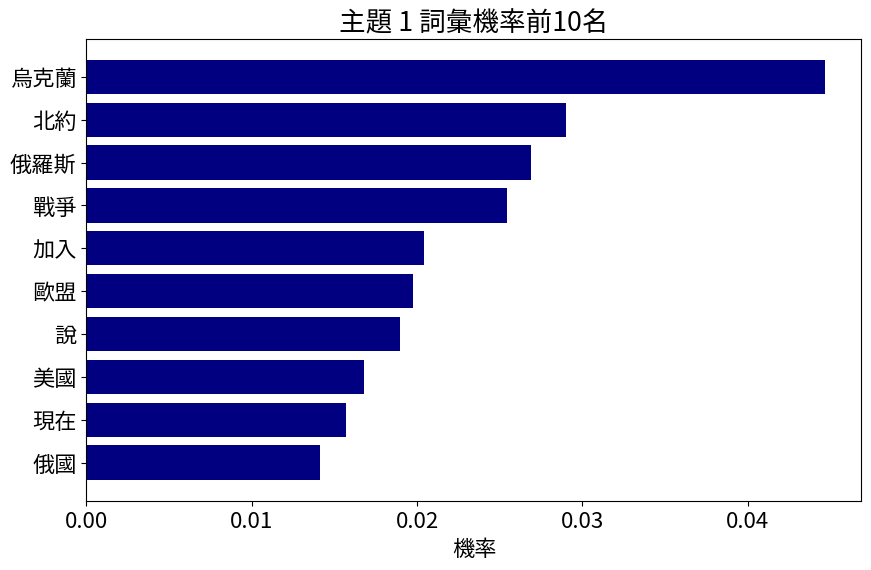

In [13]:
# 視覺化顯示主題0詞彙分佈
topic_n =1
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

從上圖可以得知，「主題1」可能主要為討論俄烏戰爭的兩國互動情勢與烏克蘭總統澤倫斯基的媒體報導有關。

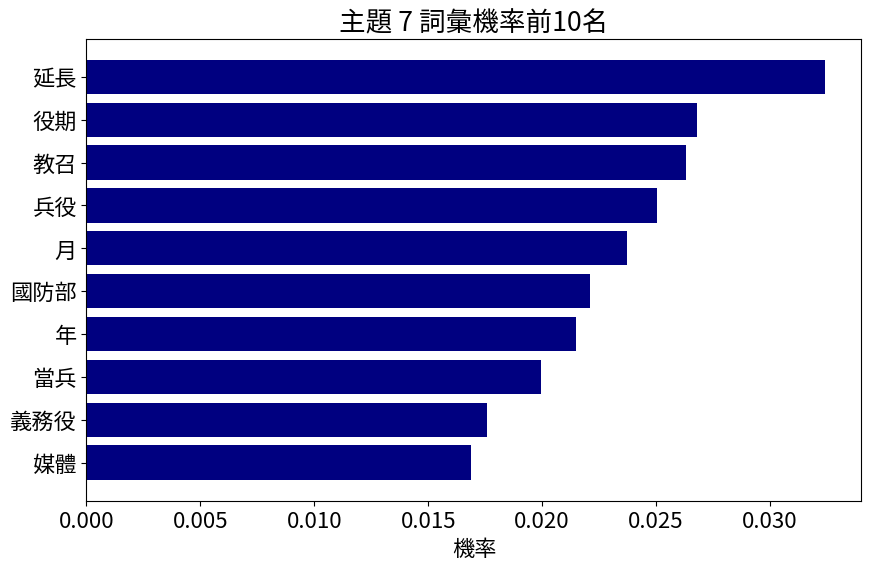

In [14]:
# 視覺化顯示主題7詞彙分佈
topic_n = 7
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()


從上圖可以得知，「主題7」可能主要為世界各國對俄羅斯提出經濟制裁之後，俄羅斯天然氣價格波動相關。